In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime


# Custom modules and packages
import params.siamese
import traversalcost.utils
from dataset import SiameseNetworkDataset
from model import SiameseNetwork
from loss import SiameseLoss
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.siamese.LEARNING

## Prepare data

In [3]:
# Create a Dataset for training
train_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for validation
# (same as training here since no transformation is applied to the data,
# train and validation sets will be split later)
val_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for testing
test_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_test.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Set the train dataset size
train_size = params.siamese.TRAIN_SIZE/(1-params.siamese.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [4]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [5]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (67736 samples)
15.0 % of the data for validation (14516 samples)
15.0 % of the data for testing (14516 samples)


## GPU?

In [6]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [7]:
# Create a model
nb_input_features = len(train_set[0][0])
model = SiameseNetwork(input_size=nb_input_features).to(device=device)

In [8]:
# Create a loss function
criterion = SiameseLoss(margin=LEARNING_PARAMS["margin"]).to(device=device)

In [9]:
# Define the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the accuracy values
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy = train(model,
                                       device,
                                       train_loader,
                                       optimizer,
                                       criterion,
                                       epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model,
                                      device,
                                      val_loader,
                                      criterion,
                                      epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy

  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.08789194489251453
Validation loss:  0.07688052825925108
Train accuracy:  74.05810794850596
Validation accuracy:  77.67291264811243


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.07418121502675798
Validation loss:  0.06934390907967668
Train accuracy:  78.43834888390221
Validation accuracy:  80.22182419399283


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.06853843634425749
Validation loss:  0.062448796976177175
Train accuracy:  80.28522499114209
Validation accuracy:  82.46073298429319


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0625460402401581
Validation loss:  0.06654138923807291
Train accuracy:  82.37569387032006
Validation accuracy:  80.91760815651695


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.05785844913693505
Validation loss:  0.05247406527761058
Train accuracy:  83.71176331640487
Validation accuracy:  85.46431523835767


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.05383267949271078
Validation loss:  0.047578730361971036
Train accuracy:  84.85738750442896
Validation accuracy:  86.79388261228989


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.048552518436110054
Validation loss:  0.04666749950055246
Train accuracy:  86.49314987598913
Validation accuracy:  87.18655276935795


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.04468277091823511
Validation loss:  0.04892142525656633
Train accuracy:  87.6003897484351
Validation accuracy:  86.45632405621383


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.04097126350879697
Validation loss:  0.03673744014575093
Train accuracy:  88.80063777016653
Validation accuracy:  90.35546982639846


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.038135952946780086
Validation loss:  0.03818216433313712
Train accuracy:  89.56389512223929
Validation accuracy:  89.74235326536235


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.03448018361704391
Validation loss:  0.03647016050778165
Train accuracy:  90.89110664934451
Validation accuracy:  90.27280242491044


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.03125037798197189
Validation loss:  0.027858896189192843
Train accuracy:  91.67798511869611
Validation accuracy:  92.73215761917884


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.029037675518204825
Validation loss:  0.027819593004176663
Train accuracy:  92.32608952403449
Validation accuracy:  92.75971341967484


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02722883990695797
Validation loss:  0.0273162451991196
Train accuracy:  92.72617219794496
Validation accuracy:  92.73215761917884


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.024493548210896728
Validation loss:  0.027748496495269337
Train accuracy:  93.58243769930317
Validation accuracy:  92.5048222650868


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02297824060428286
Validation loss:  0.02610051265347437
Train accuracy:  93.9426597378056
Validation accuracy:  93.1386056764949


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.022251355906331084
Validation loss:  0.024229695542514456
Train accuracy:  94.21430258651235
Validation accuracy:  93.46927528244696


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.019031967862656058
Validation loss:  0.019104917191116687
Train accuracy:  95.0676154482107
Validation accuracy:  95.19151281344723


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01874427841246353
Validation loss:  0.01621707388515777
Train accuracy:  95.08237864650998
Validation accuracy:  95.5910719206393


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.017945548627223043
Validation loss:  0.019233848159057848
Train accuracy:  95.36730837368607
Validation accuracy:  95.08817856158721


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.016458116624789264
Validation loss:  0.016067225637841593
Train accuracy:  95.78953584504546
Validation accuracy:  95.91485257646734


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.015155521914454368
Validation loss:  0.020256161525648596
Train accuracy:  96.08775245069091
Validation accuracy:  94.75750895563516


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01499759482538171
Validation loss:  0.019231081103274213
Train accuracy:  96.08922877052085
Validation accuracy:  94.9848443097272


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.013010500208892427
Validation loss:  0.010581044199166712
Train accuracy:  96.64875398606354
Validation accuracy:  97.37531000275558


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.013020437271479338
Validation loss:  0.01415114787239007
Train accuracy:  96.63399078776426
Validation accuracy:  96.24552218241939


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.011832311307102076
Validation loss:  0.010683669385578205
Train accuracy:  97.0798393764025
Validation accuracy:  97.5268669054836


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.011624476143332221
Validation loss:  0.010816191046166393
Train accuracy:  97.03112082201488
Validation accuracy:  97.32019840176358


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.012171103548244471
Validation loss:  0.006628465297168309
Train accuracy:  96.9366363528995
Validation accuracy:  98.53265362358776


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0104379146803976
Validation loss:  0.010197133377670323
Train accuracy:  97.3219558285107
Validation accuracy:  97.38219895287958


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010856082916217553
Validation loss:  0.008953934588719832
Train accuracy:  97.25109247667415
Validation accuracy:  97.94020391292366


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008778848950034385
Validation loss:  0.008427501832532987
Train accuracy:  97.87852840439353
Validation accuracy:  97.74042435932763


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.009352422353650625
Validation loss:  0.009616186304863066
Train accuracy:  97.6083618755167
Validation accuracy:  97.4993111049876


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008985994416231869
Validation loss:  0.007138823887275835
Train accuracy:  97.68808314633281
Validation accuracy:  98.16753926701571


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008352891202555219
Validation loss:  0.01130589827616178
Train accuracy:  97.92577063895122
Validation accuracy:  97.08597409754753


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008327168599386701
Validation loss:  0.00793518431870357
Train accuracy:  97.90805480099209
Validation accuracy:  98.1055387158997


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008460685109932458
Validation loss:  0.013229524811097966
Train accuracy:  97.85343096728475
Validation accuracy:  96.65197023973546


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008096773134622762
Validation loss:  0.008433620287474687
Train accuracy:  97.9612023148695
Validation accuracy:  97.92642601267566


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007015801634203301
Validation loss:  0.00759823301741402
Train accuracy:  98.24317940238573
Validation accuracy:  98.05731606503169


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007417240215252603
Validation loss:  0.009764504239439045
Train accuracy:  98.09259477973308
Validation accuracy:  97.4855332047396


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006718910046843452
Validation loss:  0.006119240147147803
Train accuracy:  98.30075587575293
Validation accuracy:  98.51887572333976


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00690479230002005
Validation loss:  0.007113902023398535
Train accuracy:  98.23875044289595
Validation accuracy:  98.1468724166437


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006776919926149987
Validation loss:  0.00674549988081211
Train accuracy:  98.25203732136531
Validation accuracy:  98.23642876825572


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006414777632693675
Validation loss:  0.005090730092467716
Train accuracy:  98.463151057045
Validation accuracy:  98.7599889776798


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005716199647394256
Validation loss:  0.014143925851481732
Train accuracy:  98.56944608479981
Validation accuracy:  96.28685588316341


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006137587900455545
Validation loss:  0.008474510007164551
Train accuracy:  98.44100625959608
Validation accuracy:  97.81620281069165


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006331315020502064
Validation loss:  0.005666647319751689
Train accuracy:  98.48677217432385
Validation accuracy:  98.55332047395977


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005809655629372799
Validation loss:  0.00651811653264031
Train accuracy:  98.55763552616038
Validation accuracy:  98.32598511986774


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005560322231775795
Validation loss:  0.005842448647097082
Train accuracy:  98.61521199952757
Validation accuracy:  98.51198677321577


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004518777277580936
Validation loss:  0.006830018479377031
Train accuracy:  98.92081020432266
Validation accuracy:  98.32598511986774


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004996172339779459
Validation loss:  0.00365110517516404
Train accuracy:  98.7849887799693
Validation accuracy:  99.17332598511987


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005397935178723605
Validation loss:  0.0043932146368146205
Train accuracy:  98.69345695051376
Validation accuracy:  98.95976853127583


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005039802057241161
Validation loss:  0.006568473026295919
Train accuracy:  98.74365182473132
Validation accuracy:  98.30531826949573


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005250799201861573
Validation loss:  0.003331269201153832
Train accuracy:  98.71412542813275
Validation accuracy:  99.22154863598787


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004822312112206398
Validation loss:  0.0041496104259240866
Train accuracy:  98.80860989724815
Validation accuracy:  99.00799118214384


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004688002903461175
Validation loss:  0.0032618352107391876
Train accuracy:  98.8174678162277
Validation accuracy:  99.23532653623587


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004316685554625096
Validation loss:  0.00291189707052537
Train accuracy:  98.9650997992205
Validation accuracy:  99.3731055387159


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004322446167303691
Validation loss:  0.0032529923572545533
Train accuracy:  98.94147868194166
Validation accuracy:  99.18021493524387


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005110545863060595
Validation loss:  0.00587569701109422
Train accuracy:  98.74808078422109
Validation accuracy:  98.53954257371177


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004652571532878817
Validation loss:  0.004721108575798735
Train accuracy:  98.85289949214598
Validation accuracy:  98.85643427941582


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004636812522018907
Validation loss:  0.0037693844714288146
Train accuracy:  98.84404157316641
Validation accuracy:  99.11821438412785


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00436579760872408
Validation loss:  0.003556457592281082
Train accuracy:  98.87947324908468
Validation accuracy:  99.26288233673188


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003892308276945178
Validation loss:  0.00469833435306104
Train accuracy:  99.04482107003662
Validation accuracy:  98.7737668779278


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004144782650287108
Validation loss:  0.005900263466814836
Train accuracy:  98.97986299751979
Validation accuracy:  98.48443097271976


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004764214813237882
Validation loss:  0.006906394292867131
Train accuracy:  98.86028109129562
Validation accuracy:  98.27087351887572


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004178001537014984
Validation loss:  0.0052853844124446355
Train accuracy:  98.96214715956064
Validation accuracy:  98.56020942408377


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004045795482197271
Validation loss:  0.0033018088341579825
Train accuracy:  99.03005787173733
Validation accuracy:  99.19399283549187


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003686052624829205
Validation loss:  0.0033653263794463373
Train accuracy:  99.11716074170309
Validation accuracy:  99.22154863598787


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003442988341816677
Validation loss:  0.0060277352856250585
Train accuracy:  99.15406873745128
Validation accuracy:  98.45687517222375


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004006578106823623
Validation loss:  0.001994684935518692
Train accuracy:  98.98133931734971
Validation accuracy:  99.55910719206393


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0036151435800473625
Validation loss:  0.005610258369768112
Train accuracy:  99.11716074170309
Validation accuracy:  98.54643152383576


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004178356489419895
Validation loss:  0.00507861593869486
Train accuracy:  98.99019723632928
Validation accuracy:  98.84265637916782


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0033321205915300997
Validation loss:  0.0021896909860563813
Train accuracy:  99.21164521081847
Validation accuracy:  99.53844034169192


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0030053471293339084
Validation loss:  0.004557015009158771
Train accuracy:  99.2603637652061
Validation accuracy:  98.84954532929181


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0031013926803341047
Validation loss:  0.0028677501752644385
Train accuracy:  99.28103224282509
Validation accuracy:  99.3593276384679


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0034298732392208492
Validation loss:  0.006062339113087759
Train accuracy:  99.16735561592063
Validation accuracy:  98.44998622209975


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0037698437461910488
Validation loss:  0.003071327911205754
Train accuracy:  99.05515530884611
Validation accuracy:  99.26288233673188


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002813911316538189
Validation loss:  0.0019939224474698237
Train accuracy:  99.34156135585214
Validation accuracy:  99.60044089280794


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00298359486818792
Validation loss:  0.002323089813657663
Train accuracy:  99.27807960316522
Validation accuracy:  99.47643979057591


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0031181434688278818
Validation loss:  0.0047196599322531195
Train accuracy:  99.26922168418567
Validation accuracy:  98.7737668779278


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0031773314865814334
Validation loss:  0.004206068165567478
Train accuracy:  99.24117160741703
Validation accuracy:  98.92532378065583


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002991852192674272
Validation loss:  0.0021529958690085864
Train accuracy:  99.29431912129444
Validation accuracy:  99.50399559107193


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0026684806610055697
Validation loss:  0.0023420296162202756
Train accuracy:  99.38289831109012
Validation accuracy:  99.42821713970791


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002589542955174212
Validation loss:  0.002906520512480174
Train accuracy:  99.40651942836897
Validation accuracy:  99.3455497382199


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003404973644228534
Validation loss:  0.0034419394145403796
Train accuracy:  99.1703082555805
Validation accuracy:  99.18021493524387


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0029804403858472144
Validation loss:  0.0024249688824761807
Train accuracy:  99.2766032833353
Validation accuracy:  99.48332874069992


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003298348369476112
Validation loss:  0.002641662044475257
Train accuracy:  99.19097673319948
Validation accuracy:  99.3386607880959


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0031767812182878804
Validation loss:  0.002241381867645136
Train accuracy:  99.25298216605646
Validation accuracy:  99.48332874069992


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0026746879664194313
Validation loss:  0.005244901734055533
Train accuracy:  99.40504310853903
Validation accuracy:  98.7599889776798


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0032431122159182575
Validation loss:  0.003322565400899113
Train accuracy:  99.23674264792724
Validation accuracy:  99.18710388536788


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0026491403243767415
Validation loss:  0.004177621832950295
Train accuracy:  99.39470886972954
Validation accuracy:  98.96665748139984


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003087409724489319
Validation loss:  0.0018568061300376964
Train accuracy:  99.25150584622652
Validation accuracy:  99.60044089280794


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0023159278808223176
Validation loss:  0.003883560921479886
Train accuracy:  99.48033541986536
Validation accuracy:  99.02176908239184


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0029741303267078766
Validation loss:  0.0036313373652914547
Train accuracy:  99.30317704027401
Validation accuracy:  99.09065858363185


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0026044327083260973
Validation loss:  0.0012658685456042379
Train accuracy:  99.39027991023976
Validation accuracy:  99.73821989528795


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0024881480172420723
Validation loss:  0.002632625755907287
Train accuracy:  99.43899846462737
Validation accuracy:  99.3937723890879


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0026488958926549544
Validation loss:  0.004640396434653731
Train accuracy:  99.38142199126018
Validation accuracy:  98.84265637916782


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002360692067024306
Validation loss:  0.00275219018296195
Train accuracy:  99.44933270343687
Validation accuracy:  99.3731055387159


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0023902767945548856
Validation loss:  0.0026946315820849938
Train accuracy:  99.44047478445731
Validation accuracy:  99.3317718379719


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.001910694670793974
Validation loss:  0.0026051426359702573
Train accuracy:  99.59548836659974
Validation accuracy:  99.3731055387159


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002471199202878054
Validation loss:  0.002088912098057207
Train accuracy:  99.40651942836897
Validation accuracy:  99.52466244144392


### Visualization

Text(0.5, 0, 'Epoch')

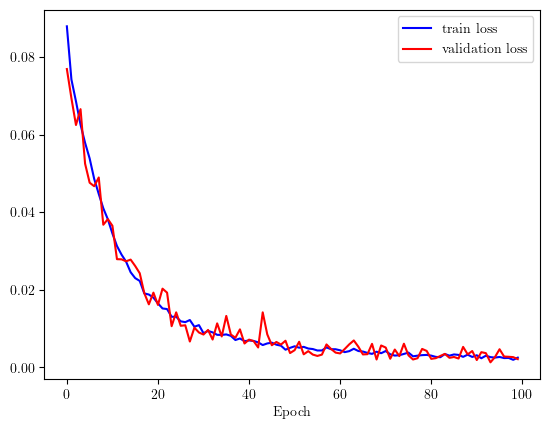

In [10]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

figure = plt.figure()

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

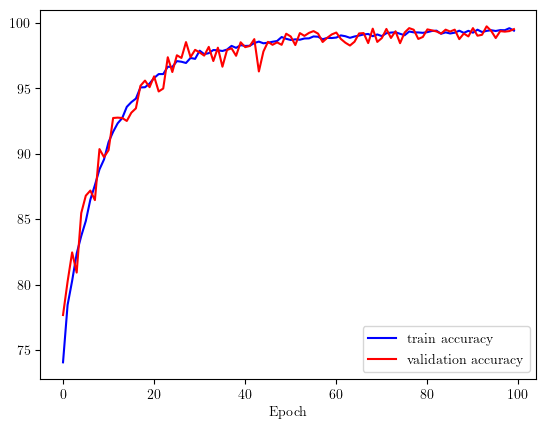

In [11]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [12]:
# Test the model
test_loss, test_accuracy = test(model,
                                device,
                                test_loader,
                                criterion)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

Test loss:  0.002200187928564354
Test accuracy:  99.48332874069992


## Compute and display traversal costs

In [13]:
# Compute the traversal costs from the features of the dataset
costs_df = traversalcost.utils.compute_traversal_costs(
    dataset=params.siamese.DATASET,
    cost_function=model.to(device="cpu"),
    to_tensor=True
)

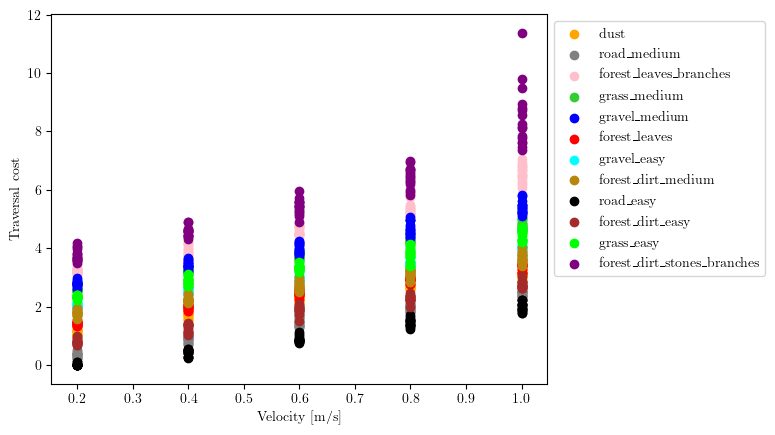

In [14]:
# Display the traversal costs
cost_graph = traversalcost.utils.display_traversal_costs(costs_df)

## Generate a log directory

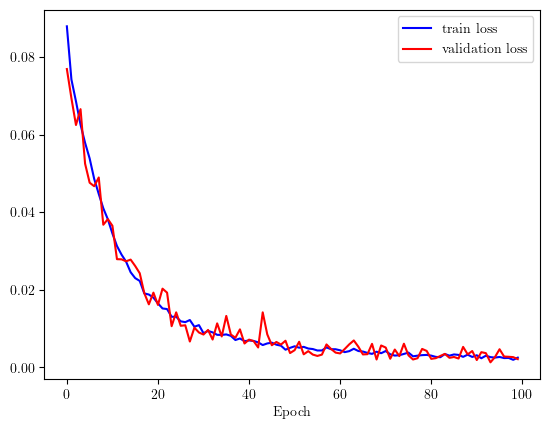

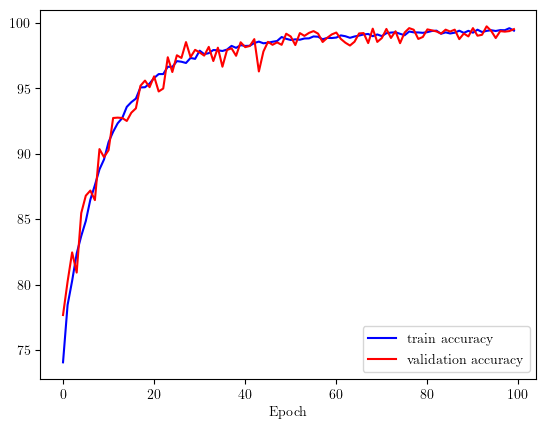

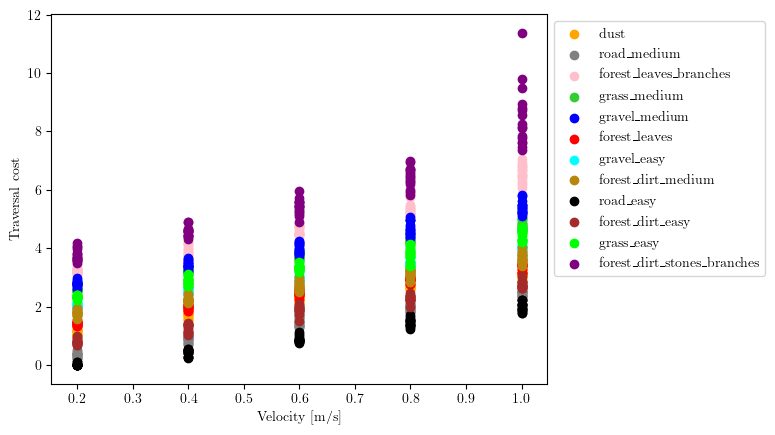

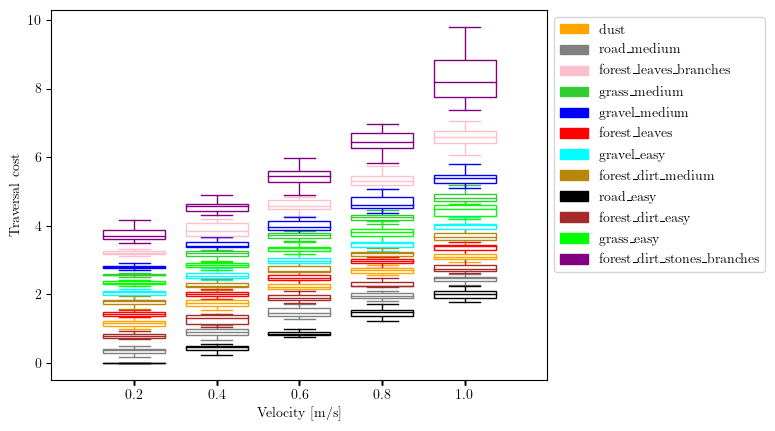

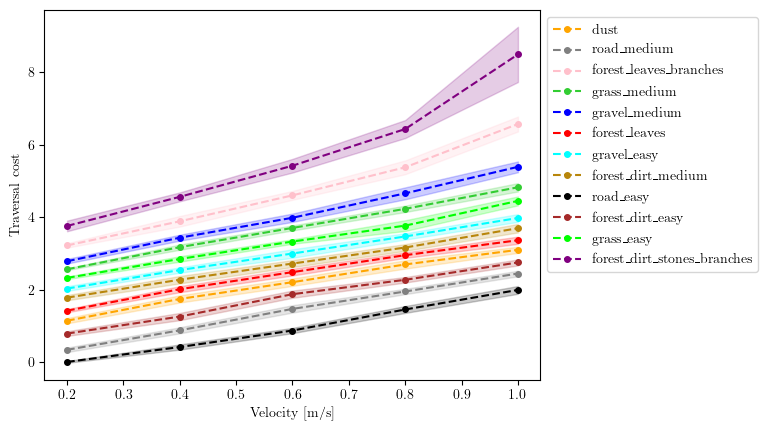

In [15]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.siamese.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.siamese.LOG_DIR:
    results_directory = "logs/_" +\
                        params.siamese.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(dataset_directory=params.siamese.DATASET,
             results_directory=results_directory,
             test_loss=test_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             loss_values=loss_values,
             accuracy_values=accuracy_values)